In [1]:
import sklearn
import numpy
import os

In [2]:
def calc_f1(true_labels,predicted_labels):
    # true_labels - list of true labels (1/-1)
    # predicted_labels - list of predicted labels (1/-1)
    # return precision, recall and f1
    
    predicted_yes = 0
    actual_yes = 0   
    predicted_yes_and_actual_yes = 0
    for i in range(len(true_labels)):
        if predicted_labels[i] == 1:
            predicted_yes += 1
        if true_labels[i] == 1:
            actual_yes += 1
        if predicted_labels[i] == 1 and true_labels[i] == 1:
            predicted_yes_and_actual_yes += 1

    precision = predicted_yes_and_actual_yes / predicted_yes
    recall = predicted_yes_and_actual_yes / actual_yes
    f1 = 2 * precision * recall / (precision + recall)
    return precision, recall, f1


In [3]:
from sklearn import svm
from sklearn.feature_extraction import DictVectorizer
from sklearn.svm import LinearSVC
class Classifier(object):
    def __init__(self, algorithm, x_train, y_train, iterations=1, averaged = False, eta = 1, alpha = 1.1):
        # Algorithm values can be Perceptron, Winnow, Adagrad, Perceptron-Avg, Winnow-Avg, Adagrad-Avg, SVM
        # Get features from examples; this line figures out what features are present in
        # the training data, such as 'w-1=dog' or 'w+1=cat'
        self.features = {feature for xi in x_train for feature in xi.keys()}
        
        if algorithm == 'Perceptron':
            #Initialize w, bias
            self.w, self.w['bias'] = {feature:0.0 for feature in self.features}, 0.0
            #Iterate over the training data n times
            for j in range(iterations):
                #Check each training example
                for i in range(len(x_train)):
                    xi, yi = x_train[i], y_train[i]
                    y_hat = self.predict(xi)
                    #Update weights if there is a misclassification
                    if yi != y_hat:
                        for feature, value in xi.items():
                            self.w[feature] = self.w[feature] + eta*yi*value
                        self.w['bias'] = self.w['bias'] + eta*yi

        elif algorithm == 'Winnow':
            #Initialize w, bias(bias is fixed)
            self.w, self.w['bias'] = {feature:1.0 for feature in self.features}, -len(self.features)
            #Iterate over the training data n times
            for j in range(iterations):
                #Check each training example
                for i in range(len(x_train)):
                    xi, yi = x_train[i], y_train[i]
                    y_hat = self.predict(xi)
                    #Update weights if there is a misclassification
                    if yi != y_hat:
                        for feature, value in xi.items():
                            self.w[feature] = self.w[feature] * alpha ** (yi*value)
                        

        elif algorithm == 'Adagrad':
            #Initialize w, bias
            self.w, self.w['bias'] = {feature:0.0 for feature in self.features}, 0.0
            #Iterate over the training data n times
            
            #Initialize G
            G, G['bias'] = {feature:0.0 for feature in self.features}, 0
            for j in range(iterations):

                for i in range(len(x_train)):
                    xi, yi = x_train[i], y_train[i]
                    #Update weight vector and bias when y*s<= 1.
                    s = sum([self.w[feature]*value for feature, value in xi.items()]) + self.w['bias']
                    if yi * s <= 1:
                        for feature, value in xi.items():  
                            G[feature] += (-yi * value) ** 2
                            self.w[feature] = self.w[feature] + eta * yi * value / (G[feature] ** 0.5)
                        G['bias'] += (-yi) ** 2
                        self.w['bias'] = self.w['bias']+ eta * yi / (G['bias'] ** 0.5)
                        
                        
        elif algorithm == 'Perceptron-Avg': 
            #Initialize w, bias
            self.w, self.w['bias'] = {feature:0.0 for feature in self.features}, 0.0  # initialize weights and bias
            self.u, self.u['bias'] = {feature:0.0 for feature in self.features}, 0.0  # initialize cached weights and bias
            c = 1                                                                     # initialize example counter to one
            #Iterate over the training data n times
            for j in range(iterations):
                # Iterate over every xi, yi in x_train, y_train
                for i in range(len(x_train)):
                    xi, yi = x_train[i], y_train[i]
                    #s = sum([self.w[feature]*value for feature, value in xi.items()]) + self.w['bias']
                    y_hat = self.predict(xi)
                    # if there is a misclassification, update.
                    if yi != y_hat:
                        for feature, value in xi.items():
                            self.w[feature] += eta*yi*value      # update weights
                            self.u[feature] += eta*yi*c*value    # update cached weights
                        self.w['bias'] += eta*yi                 # update bias
                        self.u['bias'] += eta*c*yi               # update cached bias
                    c += 1
            # return averaged weights and bias
            for feature in self.w:
                self.w[feature] = self.w[feature] - self.u[feature] / c
                       
        
        elif algorithm == 'Winnow-Avg':
            #Initialize w, bias(bias is fixed)
            self.w, self.w['bias'] = {feature:1.0 for feature in self.features}, -len(self.features)
            self.w_sum = {feature:1.0 for feature in self.features}
            
            cnt = 0
            for j in range(iterations):
                #Check each training example
                for i in range(len(x_train)):
                    xi, yi = x_train[i], y_train[i]
                    y_hat = self.predict(xi)
                    # mistake
                    if yi != y_hat:
                        for feature in self.features:
                            if feature in xi:
                                self.w[feature] = self.w[feature] * alpha ** (yi*xi[feature])
                            self.w_sum[feature] += self.w[feature]
                    # No mistake
                    else:
                        for feature in self.features:
                            self.w_sum[feature] += self.w[feature]
                    cnt += 1
            for feature in self.features:
                self.w[feature] = self.w_sum[feature] / cnt  
                        
        elif algorithm == 'Adagrad-Avg':
            #Initialize w, bias
            self.w, self.w['bias'] = {feature:0.0 for feature in self.features}, 0.0
            self.u, self.u['bias'] = {feature:0.0 for feature in self.features}, 0.0 
            c = 1
            
            #Initialize G
            G, G['bias'] = {feature:0.0 for feature in self.features}, 0
            
            #Iterate over the training data n times
            for j in range(iterations):

                for i in range(len(x_train)):
                    xi, yi = x_train[i], y_train[i]
                    #Update weight vector and bias when y*s<= 1.
                    s = sum([self.w[feature]*value for feature, value in xi.items()]) + self.w['bias']
                    if yi * s <= 1:
                        for feature, value in xi.items():  
                            G[feature] += (-yi * value) ** 2
                            delta = eta * yi * value / (G[feature] ** 0.5)
                            self.w[feature] += delta
                            self.u[feature] += c * delta
                        G['bias'] += (-yi) ** 2                        
                        self.w['bias'] += eta * yi / (G['bias'] ** 0.5)
                        self.u['bias'] += c * eta * yi / (G['bias'] ** 0.5)
                    c += 1
                    
            # return averaged weights and bias
            for feature in self.w:
                self.w[feature] = self.w[feature] - self.u[feature] / c
                    
        elif algorithm == 'SVM':
            v = DictVectorizer(sparse=True)
            x_train_vectorized = v.fit_transform(x_train)
            self.vectorizer = v
            clf = LinearSVC(penalty='l2', loss='hinge')
            self.svm = clf.fit(x_train_vectorized, y_train)
            
        else:
            print('Unknown algorithm')
                
    def predict(self, x):
        s = sum([self.w[feature]*value for feature, value in x.items()]) + self.w['bias']
        return 1 if s > 0 else -1
    
    def predict_SVM(self, x):# x is a dictionary.
        x = self.vectorizer.transform([x])
        return self.svm.predict(x)[0]

In [4]:
#Parse the real-world data to generate features, 
#Returns a list of tuple lists
def parse_real_data(path):
    #List of tuples for each sentence
    data = []
    for filename in os.listdir(path):
        with open(path+filename, 'r') as file:
            sentence = []
            for line in file:
                if line == '\n':
                    data.append(sentence)
                    sentence = []
                else:
                    sentence.append(tuple(line.split()))
    return data

In [5]:
#Returns a list of labels
def parse_synthetic_labels(path):
    #List of tuples for each sentence
    labels = []
    with open(path+'y.txt', 'rb') as file:
        for line in file:
            labels.append(int(line.strip()))
    return labels

In [6]:
#Returns a list of features
def parse_synthetic_data(path):
    #List of tuples for each sentence
    data = []
    with open(path+'x.txt') as file:
        features = []
        for line in file:
            #print('Line:', line)
            for ch in line:
                if ch == '[' or ch.isspace():
                    continue
                elif ch == ']':
                    data.append(features)
                    features = []
                else:
                    features.append(int(ch))
    return data

In [7]:
def extract_features_train(news_train_data):
    news_train_y = []
    news_train_x = []
    train_features = set([])
    for sentence in news_train_data:
        padded = sentence[:]
        padded.insert(0, ('SSS', None))
        padded.insert(0, ('SSS', None))
        padded.insert(0, ('SSS', None))
        padded.append(('EEE', None))
        padded.append(('EEE', None))
        padded.append(('EEE', None))
        for i in range(3,len(padded)-3):
            news_train_y.append(1 if padded[i][1]=='I' else -1)
            feat1 = 'w-1='+str(padded[i-1][0])
            feat2 = 'w+1='+str(padded[i+1][0])
            feat3 = 'w-2='+str(padded[i-2][0])
            feat4 = 'w+2='+str(padded[i+2][0])
            feat5 = 'w-3='+str(padded[i-3][0])
            feat6 = 'w+3='+str(padded[i+3][0])
            feat7 = 'w-1&w-2='+str(padded[i-1][0])+' '+str(padded[i-2][0])
            feat8 = 'w+1&w+2='+str(padded[i+1][0])+' '+str(padded[i+2][0])
            feat9 = 'w-1&w+1='+str(padded[i+1][0])+' '+str(padded[i-1][0])
            feats = [feat1, feat2, feat3, feat4, feat5, feat6, feat7, feat8, feat9]
            train_features.update(feats)  #!
            feats = {feature:1 for feature in feats} #!
            news_train_x.append(feats)
    return train_features, news_train_x, news_train_y

In [8]:
def extract_features_dev(news_dev_data, train_features): # for evaluation
    news_dev_y = []
    news_dev_x = []
    for sentence in news_dev_data:
        padded = sentence[:]
        padded.insert(0, ('SSS', None))
        padded.insert(0, ('SSS', None))
        padded.insert(0, ('SSS', None))
        padded.append(('EEE', None))
        padded.append(('EEE', None))
        padded.append(('EEE', None))
        for i in range(3,len(padded)-3):
            news_dev_y.append(1 if padded[i][1]=='I' else -1)
            feat1 = 'w-1='+str(padded[i-1][0])
            feat2 = 'w+1='+str(padded[i+1][0])
            feat3 = 'w-2='+str(padded[i-2][0])
            feat4 = 'w+2='+str(padded[i+2][0])
            feat5 = 'w-3='+str(padded[i-3][0])
            feat6 = 'w+3='+str(padded[i+3][0])
            feat7 = 'w-1&w-2='+str(padded[i-1][0])+' '+str(padded[i-2][0])
            feat8 = 'w+1&w+2='+str(padded[i+1][0])+' '+str(padded[i+2][0])
            feat9 = 'w-1&w+1='+str(padded[i+1][0])+' '+str(padded[i-1][0])
            feats = [feat1, feat2, feat3, feat4, feat5, feat6, feat7, feat8, feat9]
            feats = {feature:1 for feature in feats if feature in train_features}#!
            news_dev_x.append(feats)
    return news_dev_x, news_dev_y

In [9]:
def extract_features_test(test_data, train_features): 
    test_x = []
    for sentence in test_data:
        padded = sentence[:]
        padded.insert(0, ('SSS', None))
        padded.insert(0, ('SSS', None))
        padded.insert(0, ('SSS', None))
        padded.append(('EEE', None))
        padded.append(('EEE', None))
        padded.append(('EEE', None))
        for i in range(3,len(padded)-3):
            feat1 = 'w-1='+str(padded[i-1][0])
            feat2 = 'w+1='+str(padded[i+1][0])
            feat3 = 'w-2='+str(padded[i-2][0])
            feat4 = 'w+2='+str(padded[i+2][0])
            feat5 = 'w-3='+str(padded[i-3][0])
            feat6 = 'w+3='+str(padded[i+3][0])
            feat7 = 'w-1&w-2='+str(padded[i-1][0])+' '+str(padded[i-2][0])
            feat8 = 'w+1&w+2='+str(padded[i+1][0])+' '+str(padded[i+2][0])
            feat9 = 'w-1&w+1='+str(padded[i+1][0])+' '+str(padded[i-1][0])
            feats = [feat1, feat2, feat3, feat4, feat5, feat6, feat7, feat8, feat9]
            feats = {feature:1 for feature in feats if feature in train_features}#!
            test_x.append(feats)
    return test_x

In [10]:
print('Loading data...')
#Load data from folders.
#Real world data - lists of tuple lists
news_train_data = parse_real_data('Data/Real-World/CoNLL/Train/')
news_dev_data = parse_real_data('Data/Real-World/CoNLL/Dev/')
news_test_data = parse_real_data('Data/Real-World/CoNLL/Test/')
email_dev_data = parse_real_data('Data/Real-World/Enron/Dev/')
email_test_data = parse_real_data('Data/Real-World/Enron/Test/')

#Load dense synthetic data
syn_dense_train_data = parse_synthetic_data('Data/Synthetic/Dense/Train/')
syn_dense_train_labels = parse_synthetic_labels('Data/Synthetic/Dense/Train/')
syn_dense_dev_data = parse_synthetic_data('Data/Synthetic/Dense/Dev/')
syn_dense_dev_labels = parse_synthetic_labels('Data/Synthetic/Dense/Dev/')
syn_dense_dev_no_noise_data = parse_synthetic_data('Data/Synthetic/Dense/Dev_no_noise/')
syn_dense_dev_no_noise_labels = parse_synthetic_labels('Data/Synthetic/Dense/Dev_no_noise/')
syn_dense_test_data = parse_synthetic_data('Data/Synthetic/Dense/Test/')


#Load sparse synthetic data
syn_sparse_train_data = parse_synthetic_data('Data/Synthetic/Sparse/Train/')
syn_sparse_train_labels = parse_synthetic_labels('Data/Synthetic/Sparse/Train/')
syn_sparse_dev_data = parse_synthetic_data('Data/Synthetic/Sparse/Dev/')
syn_sparse_dev_labels = parse_synthetic_labels('Data/Synthetic/Sparse/Dev/')
syn_sparse_test_data = parse_synthetic_data('Data/Synthetic/Sparse/Test/')

print('Data Loaded.')

Loading data...
Data Loaded.


In [12]:
# Convert to sparse dictionary representations.

print('Converting Synthetic data...')
syn_dense_train = zip(*[  ({'x'+str(i): syn_dense_train_data[j][i]
    for i in range(len(syn_dense_train_data[j])) if syn_dense_train_data[j][i] == 1}, syn_dense_train_labels[j]) 
        for j in range(len(syn_dense_train_data))]  ) # j: row

syn_dense_train_x, syn_dense_train_y = syn_dense_train

syn_dense_dev = zip(*[({'x'+str(i): syn_dense_dev_data[j][i]
    for i in range(len(syn_dense_dev_data[j])) if syn_dense_dev_data[j][i] == 1}, syn_dense_dev_labels[j]) 
        for j in range(len(syn_dense_dev_data))])

syn_dense_dev_x, syn_dense_dev_y = syn_dense_dev

## Similarly add code for the dev set with no noise and sparse data

# Dense - dev with no noise
syn_dense_no_noise = zip(*[({'x'+str(i): syn_dense_dev_no_noise_data[j][i]
    for i in range(len(syn_dense_dev_no_noise_data[j])) if syn_dense_dev_no_noise_data[j][i] == 1}, syn_dense_dev_no_noise_labels[j]) 
        for j in range(len(syn_dense_dev_no_noise_data))]  ) # j: row
syn_dense_dev_no_noise_x, syn_dense_dev_no_noise_y = syn_dense_no_noise

# Sparse - train
syn_sparse_train = zip(*[  ({'x'+str(i): syn_sparse_train_data[j][i]
    for i in range(len(syn_sparse_train_data[j])) if syn_sparse_train_data[j][i] == 1}, syn_sparse_train_labels[j]) 
        for j in range(len(syn_sparse_train_data))]  )

syn_sparse_train_x, syn_sparse_train_y = syn_sparse_train

# Sparse - dev
syn_sparse_dev = zip(*[({'x'+str(i): syn_sparse_dev_data[j][i]
    for i in range(len(syn_sparse_dev_data[j])) if syn_sparse_dev_data[j][i] == 1}, syn_sparse_dev_labels[j]) 
        for j in range(len(syn_sparse_dev_data))])

syn_sparse_dev_x, syn_sparse_dev_y = syn_sparse_dev



print('Done')

Converting Synthetic data...
Done


In [13]:
# Sparse - Test
syn_sparse_test = [{'x'+str(i): syn_sparse_test_data[j][i] for i in range(len(syn_sparse_test_data[j])) if syn_sparse_test_data[j][i] == 1}
                   for j in range(len(syn_sparse_dev_data))]
# Dense - Test
syn_dense_test = [{'x'+str(i): syn_dense_test_data[j][i] for i in range(len(syn_dense_test_data[j])) if syn_dense_test_data[j][i] == 1}
                   for j in range(len(syn_dense_dev_data))]

In [14]:
# Feature extraction( we don't need to extract feature for synthetic data)
## Remember to add the other features mentioned in the handout
print('Extracting features from real-world data...')
train_features, news_train_x, news_train_y = extract_features_train(news_train_data)
news_dev_x, news_dev_y = extract_features_dev(news_dev_data, train_features)



Extracting features from real-world data...


In [15]:
# Feature extraction -  real test data
news_test_x = extract_features_test(news_test_data, train_features)
email_test_x = extract_features_test(email_test_data, train_features)

In [16]:
print('Extracting features from real-world Email Dev data...')

email_dev_x, email_dev_y = extract_features_dev(email_dev_data, train_features)

Extracting features from real-world Email Dev data...


In [17]:
def get_accurancy(x, y, clf):
    return sum([1 for i in range(len(y)) if clf.predict(x[i]) == y[i]])/len(x)*100

In [18]:
def get_accurancy_svm(x, y, clf):
    return sum([1 for i in range(len(y)) if clf.predict_SVM(x[i]) == y[i]])/len(x)*100

In [19]:
print('\n1 Perceptron Accuracy')
# Test Perceptron on Dense Synthetic
p = Classifier('Perceptron', syn_dense_train_x, syn_dense_train_y, iterations=10)
accuracy_train = get_accurancy(syn_dense_train_x, syn_dense_train_y, p)
print('Syn Dense Train Accuracy:', accuracy_train)

accuracy_dev= get_accurancy(syn_dense_dev_x, syn_dense_dev_y, p)
print('Syn Dense Dev Accuracy:', accuracy_dev)

accuracy_dev_no_noise= get_accurancy(syn_dense_dev_no_noise_x, syn_dense_dev_no_noise_y, p)
print('Syn Dense Without Noise Accuracy:', accuracy_dev_no_noise)


# Test Perceptron on Sparse Synthetic
p = Classifier('Perceptron', syn_sparse_train_x, syn_sparse_train_y, iterations=10)
accuracy_train = get_accurancy(syn_sparse_train_x, syn_sparse_train_y, p)
print('Syn Sparse Train Accuracy:', accuracy_train)

accuracy_dev= get_accurancy(syn_sparse_dev_x, syn_sparse_dev_y, p)
print('Syn Sparse Dev Accuracy:', accuracy_dev)


1 Perceptron Accuracy
Syn Dense Train Accuracy: 88.79
Syn Dense Dev Accuracy: 88.23
Syn Dense Without Noise Accuracy: 93.47
Syn Sparse Train Accuracy: 74.512
Syn Sparse Dev Accuracy: 74.69


In [20]:
print('\n2 Winnow Accuracy')
# Test Winnow on Dense Synthetic
w = Classifier('Winnow', syn_dense_train_x, syn_dense_train_y, iterations=10)
accuracy_train = get_accurancy(syn_dense_train_x, syn_dense_train_y, w)
print('Syn Dense Train Accuracy:', accuracy_train)

accuracy_dev= get_accurancy(syn_dense_dev_x, syn_dense_dev_y, w)
print('Syn Dense Dev Accuracy:', accuracy_dev)

accuracy_dev_no_noise= get_accurancy(syn_dense_dev_no_noise_x, syn_dense_dev_no_noise_y, w)
print('Syn Dense Without Noise Accuracy:', accuracy_dev)

# Test Winnow on Sparse Synthetic
w = Classifier('Winnow', syn_sparse_train_x, syn_sparse_train_y, iterations=10)
accuracy_train = get_accurancy(syn_sparse_train_x, syn_sparse_train_y, w)
print('Syn Sparse Train Accuracy:', accuracy_train)

accuracy_dev= get_accurancy(syn_sparse_dev_x, syn_sparse_dev_y, w)
print('Syn Sparse Dev Accuracy:', accuracy_dev)


2 Winnow Accuracy
Syn Dense Train Accuracy: 89.53
Syn Dense Dev Accuracy: 89.21
Syn Dense Without Noise Accuracy: 89.21
Syn Sparse Train Accuracy: 82.726
Syn Sparse Dev Accuracy: 82.66


In [21]:
print('\n3 Adagrad Accuracy')
# Test Adagrad on Dense Synthetic
a = Classifier('Adagrad', syn_dense_train_x, syn_dense_train_y, iterations=10)
accuracy_train = get_accurancy(syn_dense_train_x, syn_dense_train_y, a)
print('Syn Dense Train Accuracy:', accuracy_train)

accuracy_dev= get_accurancy(syn_dense_dev_x, syn_dense_dev_y, a)
print('Syn Dense Dev Accuracy:', accuracy_dev)

accuracy_dev_no_noise= get_accurancy(syn_dense_dev_no_noise_x, syn_dense_dev_no_noise_y, a)
print('Syn Dense Without Noise Accuracy:', accuracy_dev)


# Test Adagrad on Sparse Synthetic
a = Classifier('Adagrad', syn_sparse_train_x, syn_sparse_train_y, iterations=10)
accuracy_train = get_accurancy(syn_sparse_train_x, syn_sparse_train_y, a)
print('Syn Sparse Train Accuracy:', accuracy_train)

accuracy_dev= get_accurancy(syn_sparse_dev_x, syn_sparse_dev_y, a)
print('Syn Sparse Dev Accuracy:', accuracy_dev)


3 Adagrad Accuracy
Syn Dense Train Accuracy: 94.58800000000001
Syn Dense Dev Accuracy: 94.19999999999999
Syn Dense Without Noise Accuracy: 94.19999999999999
Syn Sparse Train Accuracy: 94.592
Syn Sparse Dev Accuracy: 94.49


In [22]:
print('\n4 Perceptron averaged Accuracy')
# Test Perceptron averaged on Dense Synthetic
p_avg = Classifier('Perceptron-Avg', syn_dense_train_x, syn_dense_train_y, iterations=10, averaged = True)
accuracy_train = get_accurancy(syn_dense_train_x, syn_dense_train_y, p_avg)
print('Syn Dense Train Accuracy:', accuracy_train)

accuracy_dev= get_accurancy(syn_dense_dev_x, syn_dense_dev_y, p_avg)
print('Syn Dense Dev Accuracy:', accuracy_dev)

accuracy_dev_no_noise= get_accurancy(syn_dense_dev_no_noise_x, syn_dense_dev_no_noise_y, p_avg)
print('Syn Dense Without Noise Accuracy:', accuracy_dev)

# Test Perceptron averaged on Sparse Synthetic
p_avg = Classifier('Perceptron-Avg', syn_sparse_train_x, syn_sparse_train_y, iterations=10, averaged = True)
accuracy_train = get_accurancy(syn_sparse_train_x, syn_sparse_train_y, p_avg)
print('Syn Sparse Train Accuracy:', accuracy_train)

accuracy_dev= get_accurancy(syn_sparse_dev_x, syn_sparse_dev_y, p_avg)
print('Syn Sparse Dev Accuracy:', accuracy_dev)


4 Perceptron averaged Accuracy
Syn Dense Train Accuracy: 94.58800000000001
Syn Dense Dev Accuracy: 94.19999999999999
Syn Dense Without Noise Accuracy: 94.19999999999999
Syn Sparse Train Accuracy: 94.592
Syn Sparse Dev Accuracy: 94.49


In [23]:
print('\n5 Winnow averaged Accuracy')
# Test Winnow averaged on Dense Synthetic
w_avg = Classifier('Winnow-Avg', syn_dense_train_x, syn_dense_train_y, iterations=10, averaged = True, alpha = 1.1)
accuracy_train = get_accurancy(syn_dense_train_x, syn_dense_train_y, w_avg)
print('Syn Dense Train Accuracy:', accuracy_train)

accuracy_dev= get_accurancy(syn_dense_dev_x, syn_dense_dev_y, w_avg)
print('Syn Dense Dev Accuracy:', accuracy_dev)


accuracy_dev_no_noise= get_accurancy(syn_dense_dev_no_noise_x, syn_dense_dev_no_noise_y, w_avg)
print('Syn Dense Without Noise Accuracy:', accuracy_dev)

# Test Winnow averaged on Sparse Synthetic
w_avg = Classifier('Winnow-Avg', syn_sparse_train_x, syn_sparse_train_y, iterations=10, averaged = True, alpha = 1.1)
accuracy_train = get_accurancy(syn_sparse_train_x, syn_sparse_train_y, w_avg)
print('Syn Sparse Train Accuracy:', accuracy_train)

accuracy_dev= get_accurancy(syn_sparse_dev_x, syn_sparse_dev_y, w_avg)
print('Syn Sparse Dev Accuracy:', accuracy_dev)


5 Winnow averaged Accuracy
Syn Dense Train Accuracy: 94.58800000000001
Syn Dense Dev Accuracy: 94.19999999999999
Syn Dense Without Noise Accuracy: 94.19999999999999
Syn Sparse Train Accuracy: 94.592
Syn Sparse Dev Accuracy: 94.49


In [24]:
print('\n6 Adagrad averaged Accuracy')
# Test Adagrad averaged on Dense Synthetic
a_avg = Classifier('Adagrad-Avg', syn_dense_train_x, syn_dense_train_y, iterations=10, averaged = True)
accuracy_train = get_accurancy(syn_dense_train_x, syn_dense_train_y, a_avg)
print('Syn Dense Train Accuracy:', accuracy_train)

accuracy_dev= get_accurancy(syn_dense_dev_x, syn_dense_dev_y, a_avg)
print('Syn Dense Dev Accuracy:', accuracy_dev)

accuracy_dev_no_noise= get_accurancy(syn_dense_dev_no_noise_x, syn_dense_dev_no_noise_y, a_avg)
print('Syn Dense Without Noise Accuracy:', accuracy_dev)

# Test Adagrad averaged on Sparse Synthetic
a_avg = Classifier('Adagrad-Avg', syn_sparse_train_x, syn_sparse_train_y, iterations=10, averaged = True)
accuracy_train = get_accurancy(syn_sparse_train_x, syn_sparse_train_y, a_avg)
print('Syn Sparse Train Accuracy:', accuracy_train)

accuracy_dev= get_accurancy(syn_sparse_dev_x, syn_sparse_dev_y, a_avg)
print('Syn Sparse Dev Accuracy:', accuracy_dev)


6 Adagrad averaged Accuracy
Syn Dense Train Accuracy: 94.58800000000001
Syn Dense Dev Accuracy: 94.19999999999999
Syn Dense Without Noise Accuracy: 94.19999999999999
Syn Sparse Train Accuracy: 94.52199999999999
Syn Sparse Dev Accuracy: 94.45


In [25]:
print('\n7 SVM Accuracy')
# Test  SVM on Dense Synthetic
s = Classifier('SVM', syn_dense_train_x, syn_dense_train_y, iterations=10)
accuracy_train = get_accurancy_svm(syn_dense_train_x, syn_dense_train_y, s)
print('Syn Dense Train Accuracy:', accuracy_train)

accuracy_dev= get_accurancy_svm(syn_dense_dev_x, syn_dense_dev_y, s)
print('Syn Dense Dev Accuracy:', accuracy_dev)

accuracy_dev_no_noise= get_accurancy_svm(syn_dense_dev_no_noise_x, syn_dense_dev_no_noise_y, s)
print('Syn Dense Without Noise Accuracy:', accuracy_dev)

# Test SVM on Sparse Synthetic
s = Classifier('SVM', syn_sparse_train_x, syn_sparse_train_y, iterations=10)
accuracy_train = get_accurancy_svm(syn_sparse_train_x, syn_sparse_train_y, s)
print('Syn Sparse Train Accuracy:', accuracy_train)

accuracy_dev= get_accurancy_svm(syn_sparse_dev_x, syn_sparse_dev_y, s)
print('Syn Sparse Dev Accuracy:', accuracy_dev)


7 SVM Accuracy
Syn Dense Train Accuracy: 94.58800000000001
Syn Dense Dev Accuracy: 94.19999999999999
Syn Dense Without Noise Accuracy: 94.19999999999999
Syn Sparse Train Accuracy: 94.592
Syn Sparse Dev Accuracy: 94.49


In [26]:
print('\nPerceptron Averaged F1')
# Test Perceptron averaged on News Data
p_avg = Classifier('Perceptron-Avg', news_train_x, news_train_y, iterations=10, averaged=True)

predicted_labels = []
for i in range(len(news_train_x)):
    predicted_labels.append(p_avg.predict(news_train_x[i]))
    
train_news_F1 = calc_f1(news_train_y, predicted_labels)
print('Perceptron Averaged Train F1 CONLL:', train_news_F1[2])

predicted_labels = []
for i in range(len(news_dev_x)):
    predicted_labels.append(p_avg.predict(news_dev_x[i]))
    
dev_news_F1 = calc_f1(news_dev_y, predicted_labels)
print('Perceptron Averaged Dev F1 CONLL:', dev_news_F1[2])



Perceptron Averaged F1
Perceptron Averaged Train F1 CONLL: 0.9699896617929404
Perceptron Averaged Dev F1 CONLL: 0.8111587982832618


In [27]:
print('\nPerceptron Averaged F1')
# Test Perceptron averaged on Email Data
# email_dev_x, email_dev_y
predicted_labels = []
for i in range(len(email_dev_x)):
    predicted_labels.append(p_avg.predict(email_dev_x[i]))
    
dev_email_F1 = calc_f1(email_dev_y, predicted_labels)
print('Perceptron Averaged Dev F1 Enron:', dev_email_F1[2])



Perceptron Averaged F1
Perceptron Averaged Dev F1 Enron: 0.22535211267605634


In [28]:
print('\nSVM F1')
# Test SVM on News Data
s = Classifier('SVM', news_train_x, news_train_y, iterations=10)

predicted_labels = []
for i in range(len(news_train_x)):
    predicted_labels.append(s.predict_SVM(news_train_x[i]))
    
train_news_F1 = calc_f1(news_train_y, predicted_labels)
print('SVM Train F1 CONLL:', train_news_F1[2])



predicted_labels = []
for i in range(len(news_dev_x)):
    predicted_labels.append(s.predict_SVM(news_dev_x[i]))
    
dev_news_F1 = calc_f1(news_dev_y, predicted_labels)
print('SVM Dev F1 CONLL:', dev_news_F1[2])


SVM F1
SVM Train F1 CONLL: 0.9890106643821454
SVM Dev F1 CONLL: 0.827823691460055


In [29]:
print('\nSVM Averaged F1')
# Test SVM on Email Data
predicted_labels = []
for i in range(len(email_dev_x)):
    predicted_labels.append(s.predict_SVM(email_dev_x[i]))
    
dev_email_F1 = calc_f1(email_dev_y, predicted_labels)
print('SVM Dev F1 Enron:', dev_email_F1[2])



SVM Averaged F1
SVM Dev F1 Enron: 0.24068157614483493


In [30]:
# Parameter Tunning For Winnow on Syn-Dense
print('\nWinnow Tunning -  Alpha')
alphas = [1.1, 1.01, 1.005, 1.0005, 1.0001]
max_dev_accurancy = 0
for i in range(len(alphas)):
    a = alphas[i]
    w = Classifier('Winnow', syn_dense_train_x, syn_dense_train_y, iterations=10, alpha = a)
    accuracy_dev= get_accurancy(syn_dense_dev_x, syn_dense_dev_y, w)
    if max_dev_accurancy < accuracy_dev:
        max_dev_accurancy = accuracy_dev
        best_alpha_dense = a
print("best_alpha_dense = ",best_alpha_dense)    

max_dev_accurancy = 0
for i in range(len(alphas)):
    a = alphas[i]
    w = Classifier('Winnow', syn_sparse_train_x, syn_sparse_train_y, iterations=10, alpha = a)
    accuracy_dev= get_accurancy(syn_sparse_dev_x, syn_sparse_dev_y, w)
    if max_dev_accurancy < accuracy_dev:
        max_dev_accurancy = accuracy_dev
        best_alpha_sparse = a
print("best_alpha_sparse = ",best_alpha_sparse)    



Winnow Tunning -  Alpha
best_alpha_dense =  1.0005
best_alpha_sparse =  1.005


In [31]:
print('\nAadgrad  Tunning Eta')
etas = [1.5, 0.25, 0.03, 0.05, 0.001]
max_dev_accurancy = 0
for e in etas:
    a = Classifier('Adagrad', syn_dense_train_x, syn_dense_train_y, iterations=10, eta = e)
    accuracy_dev= get_accurancy(syn_dense_dev_x, syn_dense_dev_y, a)
    if max_dev_accurancy < accuracy_dev:
        max_dev_accurancy = accuracy_dev
        best_eta_dense = e
print("best_eta_dense = ", best_eta_dense) 

max_dev_accurancy = 0
for e in etas:
    a = Classifier('Adagrad', syn_sparse_train_x, syn_sparse_train_y, iterations=10, eta = e)
    accuracy_dev= get_accurancy(syn_sparse_dev_x, syn_sparse_dev_y, a)
    if max_dev_accurancy < accuracy_dev:
        max_dev_accurancy = accuracy_dev
        best_eta_sparse = e
print("best_eta_sparse = ",best_eta_sparse)   


Aadgrad  Tunning Eta
best_eta_dense =  1.5
best_eta_sparse =  1.5


In [32]:
nums = [500 ,1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 50000]
def learning_curve(clf_name, train_x, train_y, dev_x, dev_y, nums):
    res = []
    for num in nums:
        clf = Classifier(clf_name, train_x[:num], train_y[:num], iterations=10)
        accuracy= get_accurancy(dev_x, dev_y, clf)
        res.append(accuracy)
    return res    
def learning_curve_SVM(clf_name, train_x, train_y, dev_x, dev_y, nums):
    res = []
    for num in nums:
        clf = Classifier(clf_name, train_x[:num], train_y[:num], iterations=10)
        accuracy= get_accurancy_svm(dev_x, dev_y, clf)
        res.append(accuracy)
    return res    

In [33]:
# Learning curves of algorithms
perceptron_curve     = learning_curve('Perceptron',     syn_dense_train_x, syn_dense_train_y, syn_dense_dev_x, syn_dense_dev_y, nums)
winnow_curve         = learning_curve('Winnow',         syn_dense_train_x, syn_dense_train_y, syn_dense_dev_x, syn_dense_dev_y, nums)
adagrad_curve        = learning_curve('Adagrad',        syn_dense_train_x, syn_dense_train_y, syn_dense_dev_x, syn_dense_dev_y, nums)
perceptron_avg_curve = learning_curve('Perceptron-Avg', syn_dense_train_x, syn_dense_train_y, syn_dense_dev_x, syn_dense_dev_y, nums)
winnow_avg_curve     = learning_curve('Winnow-Avg',     syn_dense_train_x, syn_dense_train_y, syn_dense_dev_x, syn_dense_dev_y, nums)
adagrad_avg_curve    = learning_curve('Adagrad-Avg',    syn_dense_train_x, syn_dense_train_y, syn_dense_dev_x, syn_dense_dev_y, nums)
SVM_curve = learning_curve_SVM('SVM', syn_dense_train_x, syn_dense_train_y, syn_dense_dev_x, syn_dense_dev_y, nums)

In [34]:
# print(perceptron_curve)
# print(winnow_curve)
# print(adagrad_curve)
# print(perceptron_avg_curve)
# print(winnow_avg_curve)
# print(adagrad_avg_curve)
# print(SVM_curve)


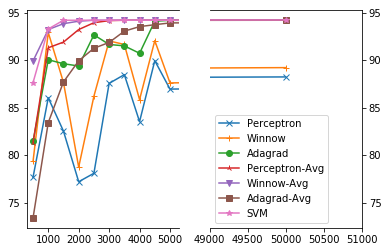

In [41]:
import matplotlib.pyplot as plt

f,(ax,ax2) = plt.subplots(1,2,sharey=True, facecolor='w')   
ax.set_xlim(300,5300)
# xticks = range(0,5500,1000)
# ax.set_yticks(xticks)
ax2.set_xlim(49000,51000)
ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax.yaxis.tick_left()
ax2.tick_params(labelright=True)
ax2.yaxis.tick_right()

l1, = ax.plot(nums, perceptron_curve,'x-')
l1, = ax2.plot(nums, perceptron_curve,'x-')
l2, = ax.plot(nums, winnow_curve,'+-')
l2, = ax2.plot(nums, winnow_curve,'+-')
l3, = ax.plot(nums, adagrad_curve,'o-')
l3, = ax2.plot(nums, adagrad_curve,'o-')
l4, = ax.plot(nums, perceptron_avg_curve,'2-')
l4, = ax2.plot(nums, perceptron_avg_curve,'2-')
l5, = ax.plot(nums, winnow_avg_curve,'v-')
l5, = ax2.plot(nums, winnow_avg_curve,'v-')
l6, = ax.plot(nums, adagrad_avg_curve,'s-')
l6, = ax2.plot(nums, adagrad_avg_curve,'s-')
l7, = ax.plot(nums, SVM_curve,'*-')
l7, = ax2.plot(nums, SVM_curve,'*-')
plt.legend(handles = [l1,l2,l3,l4,l5,l6,l7], labels = ['Perceptron','Winnow','Adagrad','Perceptron-Avg','Winnow-Avg','Adagrad-Avg','SVM'], loc = 'best')
plt.show()

In [36]:
# Learning curve points for Synthetic sparse data
perceptron_curve_sparse     = learning_curve('Perceptron',     syn_sparse_train_x, syn_sparse_train_y, syn_sparse_dev_x, syn_sparse_dev_y, nums)
winnow_curve_sparse         = learning_curve('Winnow',         syn_sparse_train_x, syn_sparse_train_y, syn_sparse_dev_x, syn_sparse_dev_y, nums)
adagrad_curve_sparse        = learning_curve('Adagrad',        syn_sparse_train_x, syn_sparse_train_y, syn_sparse_dev_x, syn_sparse_dev_y, nums)
perceptron_avg_curve_sparse = learning_curve('Perceptron-Avg', syn_sparse_train_x, syn_sparse_train_y, syn_sparse_dev_x, syn_sparse_dev_y, nums)
winnow_avg_curve_sparse     = learning_curve('Winnow-Avg',     syn_sparse_train_x, syn_sparse_train_y, syn_sparse_dev_x, syn_sparse_dev_y, nums)
adagrad_avg_curve_sparse    = learning_curve('Adagrad-Avg',    syn_sparse_train_x, syn_sparse_train_y, syn_sparse_dev_x, syn_sparse_dev_y, nums)
SVM_curve_sparse            = learning_curve_SVM('SVM',        syn_sparse_train_x, syn_sparse_train_y, syn_sparse_dev_x, syn_sparse_dev_y, nums)

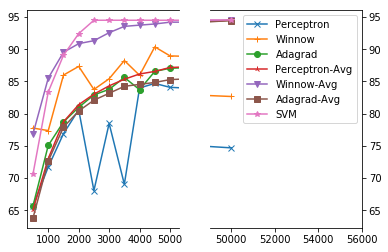

In [37]:
# Plot the Learning curve for Synthetic sparse data
f,(ax,ax2) = plt.subplots(1,2,sharey=True, facecolor='w')   
ax.set_xlim(300,5300)
# xticks = range(0,5500,1000)
# ax.set_yticks(xticks)
ax2.set_xlim(49000,56000)
ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax.yaxis.tick_left()
ax2.tick_params(labelright=True)
ax2.yaxis.tick_right()

l1, = ax.plot(nums, perceptron_curve_sparse,'x-')
l1, = ax2.plot(nums, perceptron_curve_sparse,'x-')
l2, = ax.plot(nums, winnow_curve_sparse,'+-')
l2, = ax2.plot(nums, winnow_curve_sparse,'+-')
l3, = ax.plot(nums, adagrad_curve_sparse,'o-')
l3, = ax2.plot(nums, adagrad_curve_sparse,'o-')
l4, = ax.plot(nums, perceptron_avg_curve_sparse,'2-')
l4, = ax2.plot(nums, perceptron_avg_curve_sparse,'2-')
l5, = ax.plot(nums, winnow_avg_curve_sparse,'v-')
l5, = ax2.plot(nums, winnow_avg_curve_sparse,'v-')
l6, = ax.plot(nums, adagrad_avg_curve_sparse,'s-')
l6, = ax2.plot(nums, adagrad_avg_curve_sparse,'s-')
l7, = ax.plot(nums, SVM_curve_sparse,'*-')
l7, = ax2.plot(nums, SVM_curve_sparse,'*-')
plt.legend(handles = [l1,l2,l3,l4,l5,l6,l7], labels = ['Perceptron','Winnow','Adagrad','Perceptron-Avg','Winnow-Avg','Adagrad-Avg','SVM'], loc = 'best')
plt.show()


In [38]:
# Perdicted Label - Averaged Perceptron

# 1.Averaged Perceptron - Syn Dense
p_avg = Classifier('Perceptron-Avg', syn_dense_train_x, syn_dense_train_y, iterations=10, averaged = True)
with open('p-dense.txt','w') as f:
    for i in range(len(syn_dense_test)):
        xi = syn_dense_test[i]
        y_hat = p_avg.predict(xi)
        f.write(str(y_hat)+'\n')
    
# 2. Averaged Perceptron - Syn sparse
p_avg = Classifier('Perceptron-Avg', syn_sparse_train_x, syn_sparse_train_y, iterations=10, averaged = True)
with open('p-sparse.txt','w') as f:
    for i in range(len(syn_sparse_test)):
        xi = syn_sparse_test[i]
        y_hat = p_avg.predict(xi)
        f.write(str(y_hat)+'\n')
    

# 3. Averaged Perceptron - News 
p_avg = Classifier('Perceptron-Avg', news_train_x, news_train_y, iterations=10, averaged=True)
i = 0
with open('p-conll.txt','w') as f:
    for sentence in news_test_data:
        for word in sentence:            
            xi = news_test_x[i]
            y_hat = p_avg.predict(xi)
            line = word[0]+(' I' if y_hat==1 else ' O')
            f.write(line+'\n')
            i += 1
        f.write('\n')

# 4. Averaged Perceptron - Email 
p_avg = Classifier('Perceptron-Avg', news_train_x, news_train_y, iterations=10, averaged=True)
i = 0
with open('p-enron.txt','w') as f:
    for sentence in email_test_data:
        for word in sentence:            
            xi = email_test_x[i]
            y_hat = p_avg.predict(xi)
            line = word[0]+(' I' if y_hat==1 else ' O')
            f.write(line+'\n')
            i += 1
        f.write('\n')
    

In [39]:
# Perdicted Label - SVM

# 1. SVM - Syn Dense
s = Classifier('SVM', syn_dense_train_x, syn_dense_train_y)
with open('svm-dense.txt','w') as f:
    for i in range(len(syn_dense_test)):
        xi = syn_dense_test[i]
        y_hat = s.predict_SVM(xi)
        f.write(str(y_hat)+'\n')

# 2. SVM - Syn sparse
s = Classifier('SVM', syn_sparse_train_x, syn_sparse_train_y)
with open('svm-sparse.txt','w') as f:
    for i in range(len(syn_sparse_test)):
        xi = syn_sparse_test[i]
        y_hat = s.predict_SVM(xi)
        f.write(str(y_hat)+'\n')
        
# 3. SVM - News 
s = Classifier('SVM', news_train_x, news_train_y)
i = 0
with open('svm-conll.txt','w') as f:
    for sentence in news_test_data:
        for word in sentence:            
            xi = news_test_x[i]
            y_hat = s.predict_SVM(xi)
            line = word[0]+(' I' if y_hat==1 else ' O')
            f.write(line+'\n')
            i += 1
        f.write('\n')

# 4. SVM - Email 
s = Classifier('SVM', news_train_x, news_train_y)
i = 0
with open('svm-enron.txt','w') as f:
    for sentence in email_test_data:
        for word in sentence:            
            xi = email_test_x[i]
            y_hat = s.predict_SVM(xi)
            line = word[0]+(' I' if y_hat==1 else ' O')
            f.write(line+'\n')
            i += 1
        f.write('\n')
            